#Fun with MNIST
Convolutional Neural Networks (CNNs) are able to solve a wide range of computer vision tasks. In this Lab you will learn about

- Image classification
- Convolutional AutoEncoders
- Denoising AutoEncoders
- Image super resolution
- Image regression
- Image segmentation
- Object detection
- Few-shot learning with Siamese networks
- Generative Adversarial Networks (GANs)

The purpose of the Lab is to give your some intuition about how to tweak CNNs to solve different tasks.

**Before we start - remember to set runtime to GPU**

##Task 1: Downloading and pre-processing the MNIST dataset
The MNIST dataset of handwritten digits is so commonly used that it comes with most deep learning frameworks, including Keras. Let's download the dataset and explore a little bit.

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step


###Questions 1.1
1. What is the input shape?
2. How many training examples are there?
3. How many test examples are there?
4. What does `to_categorical` do?

##Task 2: Logistic regression
Now, let's define a tiny Keras model for logistic regression. Mathematically this model outputs a 10-dimensional vector `y` of class probabilities, where


```
y = softmax(W*x + b)
```

and
- `x` is a 28x28 = 784-dimensional vector corresponding to the input image, 
- `W` is a 10 x 784 matrix of weights
- `b` is a 10-dimensional vector of biases

Defining models in Keras is not very intuitive from a mathematical perspective. Here is one way to implement the equation above using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). A Sequential model is a just a linear stack of layers.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

###Questions 2.1
1. What does Flatten() do and why is it necessary to have it here?
2. What does Dense() do, and why does it have 7850 parameters?
3. What does Activation() do?

###Training

Now, let's train the model for 10 iterations (epochs). We will be using the cross entropy loss for multiple classes and stochastic gradient descent (SGD). The difference between normal gradient descent and SGD is that normal gradient descent calculates the gradients based on all training examples, whereas SGD approximates the gradient by calculating it on small batches (of size 128 in this example).

In [0]:
batch_size = 128
epochs = 10

# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

###Model evaluation
You can visualize the loss and accuracy curves like this:

In [0]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

show_history(history)

###Task 2.1: Training on a smaller data set
Training on the entire MNIST training data set is guaranteed to work (almost) always. Simply because of the large number of images in the training set. This is boring. So let's make our problem a little more challenging by reducing the number of training examples to just 10 from each class. 

In [0]:
import numpy as np

# create smaller training set
digit_indices = np.asarray([np.where(np.argmax(y_train,axis=1) == i)[0][np.random.randint(0,5000,10)] for i in range(num_classes)]).flatten()
x_train_small = x_train[digit_indices,:]
y_train_small = y_train[digit_indices,:]

... and re-train the model:

In [0]:
batch_size = 100 # There are only 10 x 10 training images, so batch size should be 100
epochs = 200 # We need more epoch becaue we have fewer training samples

# Model (redefine the model in order to reinitialize the weights to random values)
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model before training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model (this will take a little while. Set verbose to 1 if you want to see how training progresses)
history = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            verbose=0,
            shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot old vs new loss
show_history(history)

###Question 2.2
1. What is the accuracy of our model on the small data set?

###Task 2.2: Finding a better learning rate
Your task is to find a better learning rate than the default used above, which is 0.01. You can adjust the learning rate by setting the `lr` argument of keras.optimizer.SGD:

```
keras.optimizers.SGD(lr=0.01)
```

To make the process of finding a better learning rate faster, you may want to initially lower the number of epochs. When you are done searhing for a better learning rate, retrain your model with 200 epochs.


###Task 2.3: Displaying the learned weights
Figure out a way to extract the learned weight matrix `W` from the model.

Then display them as images (there are 10 classes and one 28x28 weight image per class):

What do you observe?

In [0]:
W = # Your code goes here
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Task 2.4: Weight decay
With only 10 observations per class in our training data set, it is very likely that our model overfits the training data. This leads to poor generalization (i.e., the model doesn't work that well on unseen data).

One way to avoid overfitting is by means of regularization. The best kind of regularization is "adding more data" (of course). Another possibility is to use weight decay.

So let's try to modify the loss function of the model by adding an L2 regularization term. The regularization term is added using an extra parameter to the Dense layer function.

Compare the performance (accuracy) with the first model with the default learning rate. Don't expect a huge gain in performance (I got 70%).

In [0]:
epochs = 200

# lamda is the weight of the L2 penalty term
lamda = 1
L2_regularizer = keras.regularizers.l2(lamda)

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes,
                activation='softmax',
                kernel_regularizer=L2_regularizer))

# Training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])
history_reg = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot old vs new loss
print("Loss curves with old learning rate (0.01)")
show_history(history)
print("Loss curves with new learning rate (0.1)")
show_history(history_reg)

**Now comes the interesting part:** Try once more to display the weights - this time of the regularized model.

In [0]:
#W = # Your code goes here
W = W.reshape((28,28,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Questions 2.2
1. How do the weights of the regularized model differ from the weights of the non-regularized model?
2. Can you explain why?.

###Functional API instead of Sequential API
The models above have been specified using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). Keras also allows you to specify models a [Functional API](https://keras.io/getting-started/functional-api-guide/). The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

Here is how to set up the logistic regression model using the functional API:

In [0]:
from keras.layers import Input
from keras.models import Model

# This returns a tensor
inputs = Input(shape=input_shape)

# a layer instance is callable on a tensor, and returns a tensor
x = Flatten()(inputs)
x = Dense(num_classes)(x)
predictions = Activation('softmax')(x)

# This creates a model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

# Training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

##Task 3: Our first CNN
Here we will build and train our own CNN:

In [0]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

###Questions 3.1
1. How may layers does this CNN have?
2. What does the MaxPooling2D layer do?
3. What does the Dropout layer do?
4. What is the shape of the input of the last convolutiona layer (i.e., just before the flatten layer)

For the record, the same model can also be defined using the sequential API:


```
from keras.layers import Dropout
from keras.layers import Conv2D ![alt text](https://), MaxPooling2D

input_img = Input(shape=(28, 28, 1))
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64,
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
```



###Training
Let's train our model

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
show_history(history)

The CNN should perform better than the logistic regression model.

###Task 3.1
In the above model the input shape to the Flatten layer  is 3x3x32, which is then flattened to a 288-dimensional vector (this is the variable named `encoded`)

Your task is to modify the network such that variable `encoded` has dimensionality 2 instead of 288.

Hint: You could insert an extra layer before the Flatten layer that reduces the 3x3x32 input tensor to a 1x1x2 tensor. There are several solutions.

In [0]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = # Your code goes here
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

###Training
Now, train the modified model:

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

###Task 3.2
Run all test examples (x_test) through your model and for each example extract the 2-dimensional vector output of the Flatten layer (variable named `encoded`)

Then plot those vectors in a 2D plot, where each class gets its own color.

You might find this code useful:

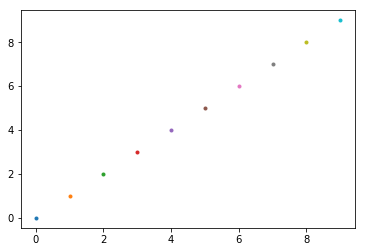

In [0]:
model_encoded = Model(inputs=model.input, outputs=encoded)

# Plot 10 dots with 10 different colors
for i in range(10):
  plt.plot(i,i,'.C'+str(i))

###Comment
The point of this little exercise is to show you that you can use CNN encoders to compress images down to just 2 dimensions. This is a powerful tool for visualization. In this example, the 2D representation actually separates the 10 classes quite nicely.

##Task 4: Convolutional Autoencoder
Autoencoders are special types of neural networks that map the input X to the same output (namely X). So the autoencoder (AE) is an identity function:

```
X = AE(X)
```

So what's the point? The point is that the autoencoder compresses the image down to a low-dimensional representation, which can be decoded again to reconstruct the original input image. This has many useful applications, such as data compression and representation learning. Only the important information is stored in the low-dimensional representation.

The autoencoder consists of a trained encoder (E) and a trained decoder (D):

```
X = AE(X) = D(E(X))
```

It is typically (but not always) the encoding E(X) that we are interested in.

Note that the autoecoder does not need the class labels to train. So it is an *unsupervised* machine learning technique.

Here is an example of a convolutional autoencoder:

In [0]:
from keras.layers import UpSampling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid')(x)
print(("shape of decoded", K.int_shape(decoded)))

autoencoder = Model(inputs, decoded)
autoencoder.summary()

###Questions 4.1
1. What is the shape of the encoded image?
2. Why are we not flattening (i.e., vectorizing) the encoded image like we did before?
3. What does UpSampling2D do?
4. Why do you think upsampling is followed by a convolution?
5. What is the difference between using `padding='same'` and `padding='valid'`?

###Training
Let's train the autoencoder:

In [0]:
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(x_train, x_train, epochs=20, batch_size=128,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

In [0]:
# utility function for showing images
def show_imgs(x_test, n=10):
    sz = x_test.shape[1]
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(sz,sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
decoded_imgs = autoencoder.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

###Improving the autoencoder
This is good, but not great. Let's use cross entropy loss instead. This requires that the decoding is a probability, hence the sigmoid below:

In [0]:
decoded_sigmoid = Activation('sigmoid')(decoded) # decoded is the output of the first autoencoder
autoencoder2 = Model(inputs, decoded_sigmoid)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder2.fit(x_train, x_train, epochs=20, batch_size=128,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

input (upper row)


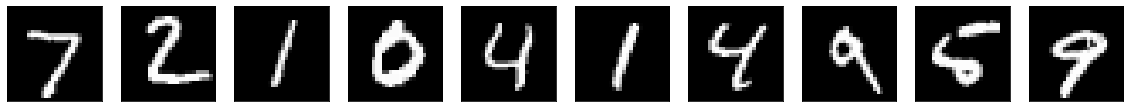

decoded (bottom row)


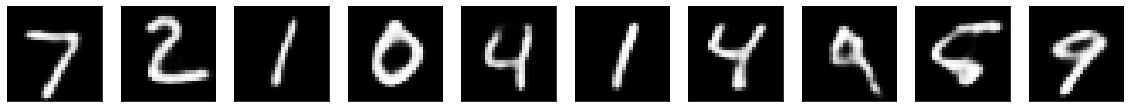

In [0]:
decoded_imgs = autoencoder2.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

###Questions 4.2
1. What is the difference between 'mse' loss and 'binary_crossentropy' loss?
2. Can you explain why 'binary_crossentropy' works better?

##Task 5: Denoising Autoencoder
Autoencoders can get really advanced, like [Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). A slightly less complicated, yet powerful autoecoder variant is the [Denoising Autoencoder](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).

As stated above autoencoders have many useful applications. One of these is *noise reduction*. The underlying idea is very simple: Add random noise to the input X, and teach the autoencoder to remove the noise. That is, the autoencoder should learn the mapping:

```
X = AE(X + noise)
```

###Task 5.1
Create two new data sets based on x_train and x_test, where you have added noise such that

```
x_train_noisy = x_train + noise
x_test_noisy = x_test + noise
```

You may want to look at numpy functions like np.random.normal and np.clip

Retrain autoencoder2 on the noisy images (input = x_train_noisy and output = x_train).

How much noise can you add before the thing breaks down?

In [0]:
#Your code goes here
#x_train_noisy = ???
#x_test_noisy = ???

In [0]:
# it takes more epochs to converge
autoencoder2.fit(x_train_noisy, x_train, epochs=10, batch_size=128,
                shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.1424 - val_loss: 0.1325
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1310 - val_loss: 0.1266
Epoch 3/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1286 - val_loss: 0.1253
Epoch 4/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1273 - val_loss: 0.1264
Epoch 5/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.1268 - val_loss: 0.1266
Epoch 6/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1260 - val_loss: 0.1239
Epoch 7/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1257 - val_loss: 0.1245
Epoch 8/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1252 - val_loss: 0.1220
Epoch 9/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1246 - val_loss: 0.1254
Epoch

In [0]:
# denoising
print("denoising")
decoded_imgs = autoencoder2.predict(x_test_noisy)
print("input (upper row)")
show_imgs(x_test_noisy)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

# what if we feed the original noise-free test images?
decoded_imgs = autoencoder2.predict(x_test)
print("\nof course, it works with original noise-less images")
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

##Task 6: Super resolution
The convolutional autoencoder is a network that maps an image to another image. There are other types of these *image-to-image networks*.

One example is a super resolution network. This is pretty much an autoencoder, except that the input image has lower spatial resolution than the output image. Super resolution networks learn to increase the spatial of the input image.

Your task is to modify the autoencoder such that it takes an 14x14x1 image as input and transforms it to a 28x28x1 image. Specifically, the training and test inputs should be



In [0]:
# Low resolution images (pick every other pixel)
x_train_small = x_train[:,::2,::2,:] 
x_test_small = x_test[:,::2,::2,:]

# Show example
print("Input low resolution images")
show_imgs(x_train_small)
print("Output high resolution images (target)")
show_imgs(x_train)

##Task 7: Image regression
Recall that regression problems are when the output of the model is one or more scalar values, rather than class labels. Both the autoencoder and super resolution network are examples of regression models. Another example of image regression is [facial landmark prediction](https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf), which can be used for emotion recognition.

In this task we will estimate the rotation angle of rotated MNIST images (but it could just as well have been estimating pixel coordinates of facial landmarks).

As a first step, we need an image generator that generates batches of randomly rotated images, along with the target rotation angles that the model should learn to predict. This code was modified from https://d4nst.github.io/2017/01/12/image-orientation/



In [0]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class RotNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = self.images.shape[0]

        super(RotNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(len(index_array), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
          
            image = self.images[j].squeeze()

            # get a random angle
            rotation_angle = np.random.randint(-45,45)

            # rotate the image
            rows,cols = image.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
            rotated_image = cv2.warpAffine(image,M,(cols,rows))

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)

###Test the generator

Images (before rotation)


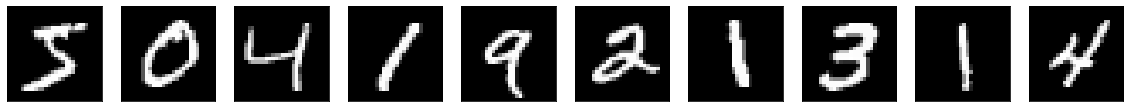

Images after random rotation


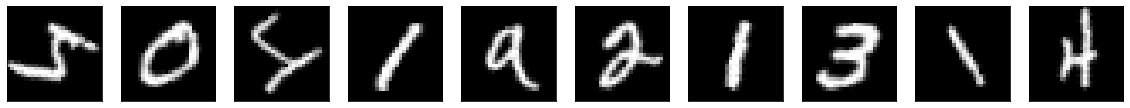

In [0]:
# Instantiate
datagen = RotNetDataGenerator(
        x_train,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate batch
rotated_images, angles = datagen.next()

# Display
print("Images (before rotation)")
show_imgs(x_train)
print("Images after random rotation")
show_imgs(rotated_images)

###Task 7.1
Make a small CNN that takes as input an 28x28x1 image and outputs a single scalar value (the rotation angle).

The last layer of your network should be

```
angle = Dense(1)(x)
```

This is a dense layer without any activation function, hence the output of this layer is simply `angle = W*x + b`.

In [0]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
# Your codes goes here

# Decoder (predict angle)
x = # Your code goes here
angle = Dense(1)(x)

angle_estimator = Model(input=inputs, output=angle)

###Training

In [0]:
angle_estimator.compile(optimizer='rmsprop',loss='mse')

# training loop
angle_estimator.fit_generator(
    RotNetDataGenerator(
        x_train,
        batch_size=128,
        preprocess_func=None,
        shuffle=True
    ),
    steps_per_epoch=80,
    epochs=100,
    validation_data=RotNetDataGenerator(
        x_test,
        batch_size=128,
        preprocess_func=None),
    validation_steps=80)

###Model evaluation

In [0]:
# Set up generator
datagen = RotNetDataGenerator(
        x_test,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate test images
rotated_images, angles = datagen.next()
print("Test images before rotation")
show_imgs(x_test)
print("Test images after rotation")
show_imgs(rotated_images)

# Predict angles
angles_pred = angle_estimator.predict(rotated_images)

# Plot angles
plt.plot(angles)
plt.plot(angles_pred)
plt.legend(['True','Predicted']);

**HELP**: The predicted angles should match the true angles reasonably well. If your model fails to predict the angles, it could be because the model is underfitting. This indicates that the capacity of the model is too low. To increase capacity, add more connections in dense layers and/or more output maps in convolutional layers (I will explain this in the class).

###De-rotate images
Now that we have estimated the rotation angles, let's de-rotate the images back to their original alignment.

In [0]:
de_rotated_images = np.zeros(rotated_images.shape)

for i in range(rotated_images.shape[0]):
  image = rotated_images[i,:,:,:].squeeze()

  # get predicted angle
  rotation_angle = -angles_pred[i]

  # rotate the image
  rows,cols = image.shape
  M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
  de_rotated_image = cv2.warpAffine(image,M,(cols,rows))

  de_rotated_images[i,:,:,0] = de_rotated_image

print('Images before rotation (ground truth)')
show_imgs(x_test)
print('Images after rotation (to be de-rotated)')
show_imgs(rotated_images)
print('De-rotated images (should match ground truth)')
show_imgs(de_rotated_images)

##Task 8: Object detection
**Motivation:** Classification CNNs assign one label to each input image. This is problematic if the image contains multiple objects. 

Object detection is about detecting and classifying multiple objects in images. Object detection networks output the corner coordinates of the bounding box of each detect object, along with a class label.

There are many ways to implement object detection with CNNs. You may want to take a look at this 3-part tutorial:
- https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375
- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/?utm_source=blog&utm_medium=a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1
- https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/?utm_source=blog&utm_medium=implementation-faster-r-cnn-python-object-detection

The basic idea of our simple object detector below is as follows:

- The output image is divided into a 2-by-2 grid
- Each grid cell can contain one object, or no object. We want our model to output whether it thinks there is an object in the cell or not.
- If a cell contains an object, we want our model to output the corner coordinates of the bounding box (relative to the center of the grid cell).
- Also, if there is an object in a cell, we want to predict its class label.

If the input image has shape 64x64, the output of the model will have shape 2x2x15:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).

This totals 15 outputs per cell.


###Task 8.1
Fill in the empty spots below (marked with ???), then run the code block to set up the object detection network.

In [0]:
from keras.layers import concatenate
from keras.activations import softmax

def softMaxAxis3(x):
    return softmax(x,axis=3)

input_img = Input(shape=(64, 64, 1))

x = Conv2D(8, 33, activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Notice that all three outputs use the same encoder

# 1. This predicts whether there is an object in a cell or not
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
confidence = Conv2D(???, 1, activation='sigmoid', padding='same')(x)

# 2. This predicts the bounding box coordinates for each cell
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
box = Conv2D(???, 1, padding='same')(x)

# 3. This predicts the class probabilities for each cell
x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
classes = Conv2D(???, 1, activation=softMaxAxis3, padding='same')(x)

# Merge output
merged = concatenate([confidence, box, classes])

objdet = Model(input_img, merged)
objdet.compile(optimizer='adagrad', loss='mse')

###Quesions 8.1
1. What does softMaxAxis3 do, and why is it needed?

###Training data
Let's generate some training data for our object detector.

The training images (`x_train_obj`) will be 64x64, where two of the four quadrants will contain one handwritten digit. This just serves to illustrate that we can teach a network to detect and classify more than one digit per input image.

The output is (`y_train_obj`) is 2x2x15 as explained above:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).


In [0]:
x_train_obj = np.zeros((5000,64,64,1))
y_train_obj = np.zeros((5000,2,2,15))

for i in range(5000):
  
  ## 1 
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,0,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,0,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,0,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,0,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,0,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,0,q,4] = np.max(cols) + y_off_start

  ## 2
  q = np.random.randint(0,2) # 3rd or 4rd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,1,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,1,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,1,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,1,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,1,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,1,q,4] = np.max(cols) + y_off_start

Display example outputs

In [0]:
import cv2
plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(y_train_obj[k,i,j,0])
      if object_present:
        class_index = np.argmax(y_train_obj[k,i,j,5:])
        xmin = int(y_train_obj[k,i,j,1] + i*32) # row
        ymin = int(y_train_obj[k,i,j,2] + j*32) # col
        xmax = int(y_train_obj[k,i,j,3] + i*32) # row
        ymax = int(y_train_obj[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Training
We are ready to start training the model.

In [0]:
objdet.fit(x_train_obj, y_train_obj, epochs=50, batch_size=128,shuffle=True,verbose=1)

###Model evaluation

In [0]:
out = objdet.predict(x_train_obj[0:10,:,:,:])

plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(out[k,i,j,0])
      if object_present:
        class_index = np.argmax(out[k,i,j,5:])
        xmin = int(out[k,i,j,1] + i*32) # row
        ymin = int(out[k,i,j,2] + j*32) # col
        xmax = int(out[k,i,j,3] + i*32) # row
        ymax = int(out[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**Note:** Do not expect perfect results. Our object detection network is over-simplified compared to state-of-the-art. Or more precisely, the loss function is far from ideal, so we are optmizing *the wrong objective*, so to say.

##Task 9: Image segmentation
Image segmentation is a form of image-to-image transformation. It outputs a softmax classification per pixel. So if the input image has size 64x64, and there are 10 classes, the output will have shape 64x64x10. That is, for each pixel the network outputs a vector of class probabilities:

![alt text](https://miro.medium.com/max/498/1*P1ooLjeSwhxeJGyFawCvaQ.png)

Source of inspiration: https://medium.com/100-shades-of-machine-learning/https-medium-com-100-shades-of-machine-learning-rediscovering-semantic-segmentation-part1-83e1462e0805

Let's first make a new training set.

###Training images
The training images (x_train_seg) will be 64x64, where two of the four quadrants will contain one handwritten digit. This is to illustrate that we can teach a network to identify and segment more than one digit per input image.

The target output (`y_train_seg`) will be 64x64x10, with a one-hot vector for each pixel indicating the correct class.

In [0]:
x_train_seg = np.zeros((5000,64,64,1))
y_train_seg = np.zeros((5000,64,64,10))

for i in range(5000):
  
  ## 1
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()
  
  ## 2
  q = np.random.randint(0,2) #  3rd or 4th image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()

In [0]:
# Show examples of input to output mappings
for ex in range(5):
  plt.figure(figsize=(20,6))
  rand_ix = np.random.randint(0,5000)
  ax = plt.subplot(1,11,1)
  plt.imshow(x_train_seg[rand_ix,:,:,:].squeeze())
  plt.title('Input image')
  for i in range(10):
    ax = plt.subplot(1,11,i+2)
    plt.imshow(y_train_seg[rand_ix,:,:,i].squeeze())
    plt.title("Out class "+str(i))

###U-Net for image segmentation
We will use a light version of the so-called U-Net:
- https://arxiv.org/pdf/1505.04597.pdf
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

![alt text](https://miro.medium.com/max/720/1*OkUrpDD6I0FpugA_bbYBJQ.png)

In [0]:
from keras.layers import concatenate

# See last layer of network
def softMaxAxis3(x):
    return softmax(x,axis=3)

inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

# Decoder
up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv10 = Conv2D(num_classes, 1, activation = softMaxAxis3)(conv9)

model = Model(input = inputs, output = conv10)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-3), loss = 'binary_crossentropy')

###Questions 9.1
1. What does "concatenate" do?
2. Which layers of the encoder are being concated with which layers of the decoder?
3. Why do you think U-Net concatenates outputs from layers of the encoder and layers of the decoder?

Hint: Use K.int_shape(...) to get the shapes of the layers that are being concatenated

###Training

In [0]:
model.fit(x_train_seg, y_train_seg, nb_epoch=30, batch_size=64,shuffle=True,verbose=1)

###Model evaluation

In [0]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('True ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###Task 9.1
Remove the concatenation layers (i.e., fill in the empty slots marked with ???). Then run the code block and train the model.

In [0]:
inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

# Decoder
up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv10 = Conv2D(num_classes, 1, activation = softMaxAxis3)(conv9)

model = Model(input = inputs, output = conv10)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-3), loss = 'binary_crossentropy')

###Training
Train the model

In [0]:
model.fit(x_train_seg, y_train_seg, nb_epoch=30, batch_size=64,shuffle=True,verbose=1)

###Model evaluation

In [0]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('True ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###Questions 9.2
1. Compare the results with and without the concatenation layers. What do you observe? Can you explain it?

##10 Ideas for further work:
###Few-shot learning (or one-shot learning) with Siamese networks
What? Why? How?

Can you modify the code below to train on just 10 examples of each class?

Read here: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

Code here: https://keras.io/examples/mnist_siamese/

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

###Generative Adversarial Networks
What on earth is this thing doing? See if you can guess :-)

Read here: https://towardsdatascience.com/dcgans-deep-convolutional-generative-adversarial-networks-c7f392c2c8f8

Code here: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import sys

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=500):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure()
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("mnist_%d.png" % epoch)
        plt.show()

if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=500)